# Test problem 2: Flow past a cylinder
Author: Jørgen S. Dokken

In this section, we will turn our attention to a slightly more challenging problem: flow past a cylinder. The geometry and parameters are taken from the [DFG 2D-2 benchmark](http://www.featflow.de/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html) in FeatFlow.

The computational geometry we would like to use is
![Fluid channel with a circular obstacle](turek.png)

The kinematic velocity is given by $\nu=0.001=\frac{\mu}{\rho}$ and the inflow velocity profile is specified as
```{math}
    u(x,y,t) = \left( 1.5\cdot \frac{4y(0.41-y)}{0.41^2}, 0 \right)
```
which has a maximum magnitude of $1.5$ at $y=0.41/2$. We do not use any scaling for this problem since all exact parameters are known. 
# Mesh generation
As in the [Deflection of a membrane](./../chapter1/membrane_code.ipynb) we use GMSH to generate the mesh. We fist create the rectangle and obstacle.

In [1]:
import gmsh
gmsh.initialize()
L = 2.2
H = 0.41
c_x = c_y =0.2
r = 0.05
gdim = 2
rectangle = gmsh.model.occ.addRectangle(0,0,0, L, H, tag=1)
obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

The next step is to subtract the obstacle from the channel, such that we do not mesh the interior of the circle.

In [2]:
fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
gmsh.model.occ.synchronize()

To get GMSH to mesh the fluid, we add a physical volume marker

In [3]:
fluid_marker = 1
volumes = gmsh.model.getEntities(dim=gdim)
gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

To tag the different surfaces of the mesh, we tag the inflow (left hand side) with marker 2, the outflow (right hand side) with marker 3 and the fluid walls and obstacles with marker 4. We will do this by compute the center of mass for each geometrical entitiy.

In [4]:
import numpy as np
inlet_marker, outlet_marker, wall_marker = 2, 3, 4
inflow, outflow, walls = [], [], []
boundaries = gmsh.model.getBoundary(volumes[0])
for boundary in boundaries:
    center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
    if np.allclose(center_of_mass, [0, H/2, 0]):
        inflow.append(boundary[1])
    elif np.allclose(center_of_mass, [L, H/2, 0]):
        outflow.append(boundary[1])
    else:
        walls.append(boundary[1])
gmsh.model.addPhysicalGroup(1, walls, wall_marker)
gmsh.model.setPhysicalName(1, wall_marker, "Walls")
gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")


We are now ready to generate the mesh

In [5]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",r/2)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",r/2)
gmsh.model.mesh.generate(gdim)
gmsh.write("mesh.msh")

## Loading mesh and boundary markers
As we have generated the mesh, we now need to load the mesh and corresponding facet markers into dolfin-X.
To load the mesh, we follow the same structure as in  [Deflection of a membrane](./../chapter1/membrane_code.ipynb), with slight modifications to include the facet markers. To learn more about the specifics of the function below, see [A GMSH tutorial for dolfin-X](http://jsdokken.com/converted_files/tutorial_gmsh.html).

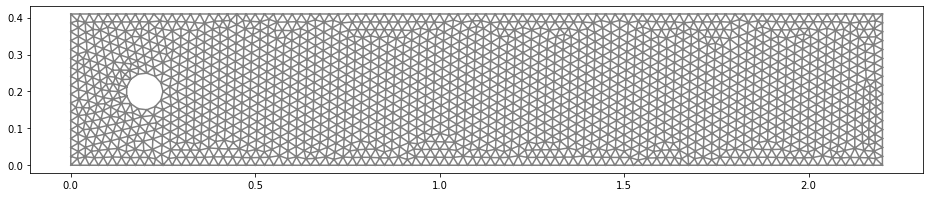

In [9]:
from mpi4py import MPI
from dolfinx.io import extract_gmsh_geometry, extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh
from dolfinx.cpp.io import perm_gmsh, extract_local_entities
from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.cpp.graph import AdjacencyList_int32
from dolfinx.mesh import create_meshtags, create_mesh
if MPI.COMM_WORLD.rank == 0:
    # Get mesh geometry
    x = extract_gmsh_geometry(gmsh.model)

    # Get mesh topology for each element
    topologies = extract_gmsh_topology_and_markers(gmsh.model)
    # Get information about each cell type from the msh files
    num_cell_types = len(topologies.keys())
    cell_information = {}
    cell_dimensions = np.zeros(num_cell_types, dtype=np.int32)
    for i, element in enumerate(topologies.keys()):
        properties = gmsh.model.mesh.getElementProperties(element)
        name, dim, order, num_nodes, local_coords, _ = properties
        cell_information[i] = {"id": element, "dim": dim, "num_nodes": num_nodes}
        cell_dimensions[i] = dim

        # Sort elements by ascending dimension
        perm_sort = np.argsort(cell_dimensions)

        # Broadcast cell type data and geometric dimension
        cell_id = cell_information[perm_sort[-1]]["id"]
        tdim = cell_information[perm_sort[-1]]["dim"]
        num_nodes = cell_information[perm_sort[-1]]["num_nodes"]
        cell_id, num_nodes = MPI.COMM_WORLD.bcast([cell_id, num_nodes], root=0)
    if tdim - 1 in cell_dimensions:
        num_facet_nodes = MPI.COMM_WORLD.bcast( cell_information[perm_sort[-2]]["num_nodes"], root=0)
        gmsh_facet_id = cell_information[perm_sort[-2]]["id"]
        marked_facets = topologies[gmsh_facet_id]["topology"]
        facet_values = topologies[gmsh_facet_id]["cell_data"]

    cells = topologies[cell_id]["topology"]
    cell_values = topologies[cell_id]["cell_data"]

else:
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, x = numpy.empty([0, num_nodes]), numpy.empty([0, gdim])
    cell_values = numpy.empty((0,))
    if facet_data:
        num_facet_nodes = MPI.COMM_WORLD.bcast(None, root=0)
        marked_facets = numpy.empty((0, num_facet_nodes))
        facet_values = numpy.empty((0,))

# Create distributed mesh
ufl_domain = ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = perm_gmsh(to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]
mesh = create_mesh(MPI.COMM_WORLD, cells, x[:, :gdim], ufl_domain)
tdim = mesh.topology.dim
fdim = tdim - 1
# Permute facets from MSH to Dolfin-X ordering
facet_type = cell_entity_type(to_type(str(ufl_domain.ufl_cell())), fdim)
gmsh_facet_perm = perm_gmsh(facet_type, num_facet_nodes)
marked_facets = marked_facets[:, gmsh_facet_perm]

local_entities, local_values = extract_local_entities(mesh, fdim, marked_facets, facet_values)
mesh.topology.create_connectivity(fdim, tdim)
adj = AdjacencyList_int32(local_entities)
# Create dolfin-X MeshTags
ft = create_meshtags(mesh, fdim, adj, np.int32(local_values))
ft.name = "Facet tags"
import dolfinx.plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
mesh_plot = dolfinx.plotting.plot(mesh)
